In [1]:
import keras
keras.__version__

'3.4.1'

In [2]:
import os
import tensorflow as tf
from tensorflow import io as tf_io
from tensorflow import image as tf_image
from tensorflow import data as tf_data

In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = 512
NUM_CLASSES = 10

NUM_TRAIN_IMAGES = 1445
NUM_VAL_IMAGES = 450

train_images = []
train_masks = []
train_folder = r"E:\Segmentation\datasets\FloodNet-Supervised_v1.0\train\train-org-img"
for file in os.listdir(train_folder):
    train_images.append(f'{train_folder}\{file}')
    train_masks.append(f'{train_folder.replace("org", "label")}\{file[:-4]}.png')

val_images = []
val_masks = []
val_folder = r"E:\Segmentation\datasets\FloodNet-Supervised_v1.0\val\val-org-img"
for file in os.listdir(val_folder):
    val_images.append(f'{val_folder}\{file}')
    val_masks.append(f'{val_folder.replace("org", "label")}\{file[:-4]}.png')

test_images = []
test_masks = []
test_folder = r"E:\Segmentation\datasets\FloodNet-Supervised_v1.0\test\test-org-img"
for file in os.listdir(test_folder):
    val_images.append(f'{test_folder}\{file}')
    val_masks.append(f'{test_folder.replace("org", "label")}\{file[:-4]}.png')

In [47]:
def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = tf.one_hot(tf.cast(image, tf.int32), depth=10)
        # image = tf.squeeze(image, axis=-2)
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None))>


In [48]:
for input_batch, output_batch in train_dataset:
    print(input_batch.shape)
    print(output_batch.shape)
    break

(16, 512, 512, 3)
(16, 512, 512, 1)


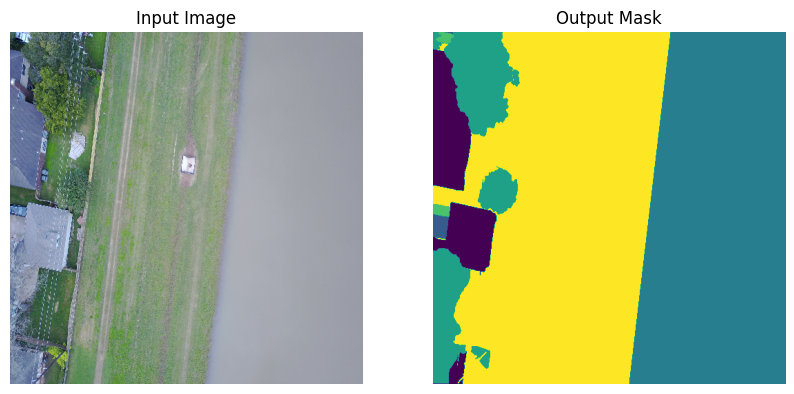

In [51]:
import matplotlib.pyplot as plt
import numpy as np

count = 0
for input_batch, output_batch in train_dataset:

    if count != 7:
        count += 1
        continue

    input_image = input_batch[0].numpy()
    output_mask = output_batch[0].numpy()

    if input_image.dtype != np.uint8 and input_image.max() > 1.0:
        input_image = input_image / 255.0

    plt.figure(figsize=(10, 5))

    # Plot the input image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.axis('off')
    plt.title('Input Image')
    
    output_mask = tf.one_hot(tf.cast(output_mask, tf.int32), depth=10)
    output_mask = tf.squeeze(output_mask, axis=-2)
    
    # Plot the output mask
    plt.subplot(1, 2, 2)
    plt.imshow(np.argmax(output_mask, axis=-1))
    plt.axis('off')
    plt.title('Output Mask')
    
    plt.show()
    break

In [53]:
from DeepLabv3 import DeeplabV3Plus

IMAGE_SIZE = 512
NUM_CLASSES = 10

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 512, 512)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 512, 512)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 512, 512)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 512, 512,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 512, 512,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 518, 518,  │          0 │ add_2[0][0]       │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 256, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 256, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 256, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 258, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 128, 128,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 128, 128,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 128, 128,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 128, 128,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 128, 128,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,854,666 (45.22 MB)

 Trainable params: 11,821,930 (45.10 MB)

 Non-trainable params: 32,736 (127.88 KB)

In [54]:
model.input_shape, model.output_shape

((None, 512, 512, 3), (None, 512, 512, 10))

In [55]:
len(model.layers)

164

In [56]:
# def jaccard_loss(y_true, y_pred, smooth=1):
#     intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
#     union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
#     iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
#     return 1 - iou

# iou_metric = keras.metrics.MeanIoU(num_classes=NUM_CLASSES) 

# model.compile(optimizer='adam', loss=jaccard_loss, metrics=[iou_metric])

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

In [57]:
train_samples = NUM_TRAIN_IMAGES
val_samples = NUM_VAL_IMAGES
train_samples, val_samples

(1445, 450)

In [58]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25


AttributeError: 'str' object has no attribute 'base_dtype'